## AMS 518. Homework 2
### Juan Perez Osorio - SBU ID: 116248538

### Problem 1
Optimization problem for finding a new tracking portfolio
$$
\min_{\vec{x}} \epsilon_{MAX}(\vec{x})
$$
subject to:
$$
\sum_{i=1}^N \delta(x_i) \leq K
$$
$$
\sum_{i=1}^N \beta_{\sigma}^{+}(x_i) \leq 0
$$
$$
\sum_{i=1}^N x_i + \sum_{i=1}^N a_i |x_i - x_i^0| + A\sum_{i=1}^N \delta(|x_i - x_i^0|) \leq C
$$
$$
\sum_{i=1}^N a_i |x_i - x_i^0| + A\sum_{i=1}^N \delta(|x_i - x_i^0|) \leq \gamma C
$$
$$
x_i \geq 0, \quad i=1, \ldots, I
$$
---

### Problem 2
MIP formulation of optimization problem
$$
\min_{y,\vec{x},\vec{v},\vec{w},\vec{z}} y
$$
subject to:
$$
y \geq \sum_{i=1}^N \theta_{ti}x_i - \theta_{t0}, \quad t=1,\ldots,T
$$
$$
y \geq -\left(\sum_{i=1}^N \theta_{ti}x_i - \theta_{t0}\right), \quad t=1,\ldots,T
$$
$$
\sum_{i=1}^N v_i \leq K
$$
$$
l_i v_i \leq x_i \leq u_i v_i, \quad i=1,\ldots,N
$$
$$
z_i \geq x_i - x_i^0, \quad i=1,\ldots,N
$$
$$
z_i \geq -(x_i - x_i^0), \quad i=1,\ldots,N
$$
$$
z_i \leq Uw_i, \quad i=1,\ldots,N
$$
$$
\sum_{i=1}^N x_i + \sum_{i=1}^N a_i z_i + A\sum_{i=1}^N w_i \leq C
$$
$$
\sum_{i=1}^N a_i z_i + A\sum_{i=1}^N w_i \leq \gamma C
$$
$$
v_i \in \{0,1\}, \quad i=1,\ldots,N
$$
$$
w_i \in \{0,1\}, \quad i=1,\ldots,N
$$
$$
x_i \geq 0, \quad i=1,\ldots,N
$$

**Assignment 1.** Use data uploaded for in-sample test. Replicate Dow Jones index by optimizing a portfolio subject to the buy-in, cardinality and budget constraints (select some values for the constraints, which make them active, do not use 10 as cardinality constraint). For solving the optimization problem, use PSG (Portfolio Safeguard). As a reference use this case study:

https://uryasev.ams.stonybrook.edu/research/testproblems/financialengineering/case−study−portfolio−replication−with−cardinality−and−buyin−constraints/

For verification purposes, build on a same graph both the portfolio value and Dow Jones value for the selected time period. (Hint: assume the initial value = 100 for both the replicating portfolio (no re-balancing) and the Dow Jones index; use rates of returns to build the cumulative return curves.)

**Solution.** We know that the DJIA index is composed by 30 prominent companies listed on stock exchanges in the United States. 

To capture the most important movements we define our replicating portfolio to be composed of 15 stocks, which is 50% the number of stocks in the DJIA index and corresponds to 30% of the total number of the stocks in the replicating basket (50). So we define our cardinality constraint $K \leq 15$.

For the budget constrain, we define a maximum capital of \$1,000,000. Hence, for the buy-in constrain we are going to define minimum positions of \$15,000 on each asset. So we have that $\sigma = 15,000$. We start by loading the data and cleaning it, as well as by defining the matrices needed to run the optimization. The following code snipped contains the cleaning process and the modification of the problem statement so it matches our constraints. 

~~~R 
library(PSG)
library(dplyr)
library(tidyr)

setwd("C:/Users/JUANJO/Documents/GitHub/ams-518/homework-2/data")

# Set your path to Rdata file including the RData file's name with CS:
load("C:/Users/JUANJO/Documents/GitHub/ams-518/homework-2/data/problem_fc_indtrack1_max_0025_short.RData")

# Load the index data and stock data and delete the date column
log_index_data <- read.csv("dow_index_daily_log_returns.csv")
log_index_data <- log_index_data[2]
stocks_data <- read.csv("stocks_50_daily_log_returns.csv")
stocks_data <- stocks_data[,-1]

# Normalize the stock data
gamma <- 0.015
C <- 1000000
stocks_data <- stocks_data / (C *(1-gamma))

# Get the tickers
stock_tickers <- names(stocks_data)
index_ticker <- names(log_index_data)

# Merge the datasets
merged_data <- cbind(stocks_data, log_index_data)

# Form a matrix out of the merged data
asset_matrix <- as.matrix(merged_data)
header <- names(merged_data)

# Set column names (tickers)
colnames(asset_matrix) <- header

# Update the inmmax matrix
problem.list$matrix_inmmax <- asset_matrix

# Create ksi matrix
# Create a matrix with 51 columns, all ones, and ksi labels
create_ksi_matrix <- function(num_assets = 51) {
  # Generate ksi labels with leading zeros
  ksi_labels <- sprintf("ksi%04d", 1:num_assets)
  
  # Create matrix with ones
  ksi_matrix <- matrix(1, nrow = 1, ncol = num_assets)
  
  # Set column names
  colnames(ksi_matrix) <- ksi_labels
  
  return(ksi_matrix)
}

# Create the ksi matrix with 51 columns
ksi_matrix <- create_ksi_matrix(51)

# Update the ksi_matrix
problem.list$matrix_ksi <- ksi_matrix

# To construct the ksibuy matrix we are going to assume that the minimum
# position we can take in an asset is $15,000
create_ksibuy_matrix <- function(num_assets = 51, value) {
  # Generate ksi labels with leading zeros
  ksibuy_labels <- sprintf("ksi%04d", 1:num_assets)
  
  # Create matrix with ones
  ksibuy_matrix <- matrix(value, nrow = 1, ncol = num_assets)
  
  # Set column names
  colnames(ksibuy_matrix) <- ksibuy_labels
  
  return(ksibuy_matrix)
}

# Create the ksibuy matrix with 51 columns and 15,000 minimum buy
ksibuy_matrix <- create_ksibuy_matrix(51, 15000)

# Update the ksibuy matrix
problem.list$matrix_ksibuy <- ksibuy_matrix

# Finally we create the ksi_pol matrix
generate_capital_allocation_matrix <- function(total_capital = 1000000, min_stocks = 20, max_stocks = 30, total_assets = 51) {
  # Generate random number of stocks between min_stocks and max_stocks
  num_selected_stocks <- sample(min_stocks:max_stocks, 1)
  
  # Generate random weights that sum to 1 for selected stocks
  weights <- runif(num_selected_stocks)
  weights <- weights / sum(weights)  # Normalize to sum to 1
  
  # Calculate capital allocation for selected stocks
  capital_allocation <- weights * total_capital
  
  # Select the FIRST N stocks (not random selection)
  selected_indices <- 1:num_selected_stocks
  
  # Create full allocation vectors for all 51 assets
  first_row <- rep(1, total_assets)  # All ones for first row
  second_row <- rep(0, total_assets)  # Zeros for second row initially
  
  # Fill in the capital allocation for the first N stocks
  second_row[selected_indices] <- capital_allocation
  
  # Create ksi labels for all 51 assets
  ksi_labels <- sprintf("ksi%04d", 1:total_assets)
  
  # Create the matrix
  allocation_matrix <- matrix(
    c(first_row, second_row),
    nrow = 2,
    ncol = total_assets,
    byrow = TRUE
  )
  
  # Set column names
  colnames(allocation_matrix) <- ksi_labels
  
  # Set row names
  rownames(allocation_matrix) <- c("[1,]", "[2,]")
  
  return(list(
    matrix = allocation_matrix,
    num_selected_stocks = num_selected_stocks,
    selected_indices = selected_indices,
    weights = weights,
    total_capital = total_capital
  ))
}

# We generate now the capital allocation matrix
result <- generate_capital_allocation_matrix()
allocation_matrix <- result$matrix

# Constraint on the number of assets in the new tracking portfolio
problem.list$problem_statement[3] <- "Constraint: <= 15" 

# Constraint prohibiting small positions
problem.list$problem_statement[5] <- "Constraint: <= 0" 

# Bound on sum of “new tracking portfolio value” + “transaction cost” <= “current tracking portfolio value”)
problem.list$problem_statement[7] <- "Constraint: <= 1E+06" 

# We assume the transaction costs are 1.5% the maximum value of the portfolio

# Upper bound on transaction cost
problem.list$problem_statement[10] <- "Constraint: <= 15000" 

# Constraint defines variable and fixed transaction costs
problem.list$problem_statement[12] <- "Constraint: <= 0" 

# Box constraints: We don't allow shorts and one position can't exceed 40% of the maximum budget for the portfolio
problem.list$problem_statement[17] <- "Box: >= 0, <= 400000"
~~~

Now we check the problem statement to validate that our new constraints are included

~~~R

# Check the problem statement
> problem.list$problem_statement
 [1] "minimize"                            "max_risk(matrix_inmmax)"            
 [3] "Constraint: <= 15"                   "cardn_pos(0.01, matrix_ksi)"        
 [5] "Constraint: <= 0"                    "buyin_pos(0.01, matrix_ksibuy)"     
 [7] "Constraint: <= 1E+06"                "linear(matrix_ksi)"                 
 [9] "+variable(trcost)"                   "Constraint: <= 15000"               
[11] "variable(trcost)"                    "Constraint: <= 0"                   
[13] "-variable(trcost)"                   "+0.01*polynom_abs(matrix_ksipol)"   
[15] "+100*cardn_pos(0.01, matrix_ksipol)" "+100*cardn_neg(0.01, matrix_ksipol)"
[17] "Box: >= 0, <= 400000"   

# Run PSG Solver to optimize problem stored in problem.list
Data successfully read from C:\Aorda\PSG25\PSG25_license.bin
Running solver
Reading problem formulation
Asking for data information
Getting data
      2.0% of scenarios is processed
100% of matrix_inmmax was read
100% of matrix_ksi was read
100% of matrix_ksibuy was read
100% of trcost was read
100% of matrix_ksipol was read
Start optimization
Ext.iteration=0  Objective=0.000000000000E+00  Residual=0.964138279463E+04
Ext.iteration=49  Objective=0.196034050794E-15  Residual=0.000000000000E+00
Start stage  1
Ext.iteration=0  Objective=0.000000000000E+00  Residual=0.000000000000E+00
Ext.iteration=12  Objective=0.000000000000E+00  Residual=0.000000000000E+00
...
...
...
Ext.iteration=0  Objective=0.000000000000E+00  Residual=-.111113399158E+03
Ext.iteration=12  Objective=0.000000000000E+00  Residual=-.111113399158E+03
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = 0.00000000000 [0.00000000000]
Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = optimal
Timing: data_loading_time = 0.17, preprocessing_time = 0.01, solving_time = 0.02
Variables: optimal_point = point_problem_1
Objective: objective = 0.00000000000 [0.00000000000]
Constraint: constraint_1 =  1.000000000000E+01 [-5.000000000000E+00]
Constraint: constraint_2 =  0.000000000000E+00 [ 0.000000000000E+00]
Constraint: constraint_3 =  4.593300458190E+05 [-5.406699541810E+05]
Constraint: constraint_4 =  1.500000000000E+04 [ 3.637978807092E-12]
Constraint: constraint_5 = -1.605348484723E+02 [-1.605348484723E+02]
Function: max_risk(matrix_inmmax) =  0.000000000000E+00
Function: cardn_pos(1.E-02,matrix_ksi) =  1.000000000000E+01
Function: buyin_pos(1.E-02,matrix_ksibuy) =  0.000000000000E+00
Function: linear(matrix_ksi) =  4.443300458190E+05
Function: variable(trcost) =  1.500000000000E+04
Function: polynom_abs(matrix_ksipol) =  1.383946515153E+06
Function: cardn_pos(1.E-02,matrix_ksipol) =  0.000000000000E+00
Function: cardn_neg(1.E-02,matrix_ksipol) =  1.000000000000E+01
OK. Solver Finished

> results$solution_status
[1] "optimal"
~~~    

~~~R
> results$output
 [1] "Problem: problem_1, solution_status = optimal"                                   
 [2] "Timing: data_loading_time = 0.17, preprocessing_time = 0.01, solving_time = 0.02"
 [3] "Variables: optimal_point = point_problem_1"                                      
 [4] "Objective: objective = 0.00000000000 [0.00000000000]"                            
 [5] "Constraint: constraint_1 =  1.000000000000E+01 [-5.000000000000E+00]"            
 [6] "Constraint: constraint_2 =  0.000000000000E+00 [ 0.000000000000E+00]"            
 [7] "Constraint: constraint_3 =  4.593300458190E+05 [-5.406699541810E+05]"            
 [8] "Constraint: constraint_4 =  1.500000000000E+04 [ 3.637978807092E-12]"            
 [9] "Constraint: constraint_5 = -1.605348484723E+02 [-1.605348484723E+02]"            
[10] "Function: max_risk(matrix_inmmax) =  0.000000000000E+00"                         
[11] "Function: cardn_pos(1.E-02,matrix_ksi) =  1.000000000000E+01"                    
[12] "Function: buyin_pos(1.E-02,matrix_ksibuy) =  0.000000000000E+00"                 
[13] "Function: linear(matrix_ksi) =  4.443300458190E+05"                              
[14] "Function: variable(trcost) =  1.500000000000E+04"                                
[15] "Function: polynom_abs(matrix_ksipol) =  1.383946515153E+06"                      
[16] "Function: cardn_pos(1.E-02,matrix_ksipol) =  0.000000000000E+00"                 
[17] "Function: cardn_neg(1.E-02,matrix_ksipol) =  1.000000000000E+01" 
~~~


As we can see, the solution found by the solver is optimal. Now we define the solution vector and check the length of this one to see if it met the cardinality constraint requirement. 

~~~R
> solution_vector <- results$point_problem_1[results$point_problem_1 != 0]
> # Checking the length we can see that the cardinality constraint has been met
> length(solution_vector)
[1] 11
~~~

Which indicates it is met since the last variable in the vector is ``trcost`` (transaction costs)

The tracking portfolio that we have obtained is

~~~R
> stocks_tracking_allocations <- results$point_problem_1
> stocks_tracking_allocations <- stocks_tracking_allocations[stocks_tracking_allocations != 0]
> stocks_tracking_allocations <- stocks_tracking_allocations[1:10]

> names(stocks_tracking_allocations) <- stock_tickers[1:length(stocks_tracking_allocations)]

# Define the portfolio weights
> portfolio_weights <- stocks_tracking_allocations / sum(stocks_tracking_allocations)
> portfolio_weights
      AAPL       MSFT       AMZN      GOOGL       META       NVDA       TSLA 
0.09969011 0.09863193 0.09968457 0.09914835 0.09968098 0.09989221 0.09952867 
     BRK.B        JPM        JNJ 
0.10007968 0.09989712 0.10376637 

> sum(portfolio_weights)
[1] 1

# To get all 51 weights
full_weights <- rep(0, 51)
full_weights[1:length(portfolio_weights)] <- portfolio_weights

# Cast returns to normal returns again
simple_asset_returns <- log_to_simple_returns(asset_matrix)
simple_dj_returns <- log_to_simple_returns(log_index_data)

# Compute portfolio cumulative returns and index cumulative returns
portfolio_returns <- simple_asset_returns %*% full_weights
portfolio_returns <- portfolio_returns * C * (1 - gamma)
portfolio_value <- 100 * cumprod(1 + portfolio_returns)
dj_value <- 100 * cumprod(1 + simple_dj_returns)

library(dplyr)
library(tidyr)
library(ggplot2)

# build data frame for plotting
df <- data.frame(
  t = 1:length(portfolio_value),
  Portfolio = as.vector(portfolio_value),
  DowJones = as.vector(dj_value)
)

# reshape to long format
library(tidyr)
df_long <- pivot_longer(df, cols = c("Portfolio", "X.DJI"),
                        names_to = "Series", values_to = "Value")

# plot
library(ggplot2)
ggplot(df_long, aes(x = t, y = Value, color = Series)) +
  geom_line(size = 1) +
  labs(title = "Portfolio vs Dow Jones",
       x = "Time (index)", y = "Cumulative Value") +
  theme_minimal()
~~~

Finally we can see that the graph of the $100 compounded over the period.

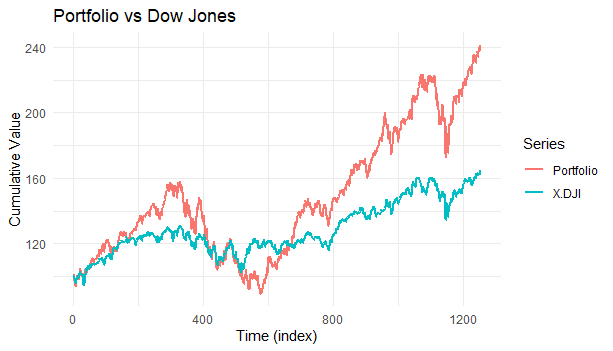

In [8]:
from IPython.display import display, Image

display(Image(filename="data/index_tracking.png"))

**Assignment 2** For each constraint in (3) - (7), point out the corresponding linearized constraints in (10) - (21). For each constraint in (3) - (7), prove that if a point $\vec{x}$ satisfies the constraint, then $\vec{x}$ satisfies the corresponding linearized constraints.

Use the preceding proof to prove the following statement: Suppose that Problem 1 has an optimal solution point $\vec{x}^*$, then there exists a vector $(y^*, \vec{x}^*, \vec{v}^*, \vec{w}^*, \vec{z}^*)$ which is a **feasible** solution point of Problem 2.

**Solution.** The second optimization problem is a mixed-integer linear programming (MIP) formulation of the first problem. Each non-linear or logical constraint in Problem 1 is represented by a set of linear constraints in Problem 2, using auxiliary binary and continuous variables. This process of linearization is what makes the problem solvable with standard MIP solvers and thus creates an equivalent optimization problem.

---

Constraint Correspondence
-------------------------
Below is the mapping of each constraint from Problem 1 to its corresponding linearized constraints in Problem 2.

* Cardinality Constraint (3) -> (12) & (19):
    * Constraint (3) is the cardinality constraint, $\sum(\delta(x_i)) \leq K$.
    * This is linearized using the binary variable $v_i$ and constraints (12), $\sum(v_i) \leq K$, and (19) since this one gives a defined value for $v_i$ of either zero or one.

* Buy-in Constraint (4) -> (13):
    * Constraint (4) is the buy-in constraint, $\sum(\beta_\sigma^+(x_i)) \leq 0$.
    * This is enforced by constraint (13), $l_i v_i \leq x_i \leq u_i v_i$, by setting the lower bound $l_i = \sigma$.

* Budget Constraint (5) -> (14), (15), (16), (17):
    * Constraint (5) is the budget constraint, including non-linear transaction costs: 
    $$\sum(x_i) + \sum(a_i | x_i - x_i^0|) + A \sum(\delta(|x_i - x_i^0|)) \leq C.$$
    * Linearized using auxiliary variables $z_i$ and $w_i$.
    * The absolute value is handled by (14), $z_i \geq x_i - x_i^0$, and (15), $z_i \geq -(x_i - x_i^0)$.
    * The fixed cost is handled by (16), $z_i \leq U * w_i$.
    * These are combined into the linear budget constraint (17): $$\sum(x_i) + \sum(a_i z_i) + A \sum(w_i) \leq C.$$

* Transaction Cost Limit (6) -> (14), (15), (16), (18):
    * Constraint (6) limits total transaction costs: 
    $$
    \sum(a_i |x_i - x_i^0|) + A \sum(\delta(|x_i - x_i^0|)) \leq \gamma C 
    $$.
    * Uses the same linearization, resulting in (18): 
    $$\sum(a_i  z_i) + A \sum(w_i) \leq \gamma  C$$

* Non-negativity Constraint (7) -> (21):
    * Constraint (7), $x_i \geq 0$, directly corresponds to (21), $x_i \geq 0$.

Proof
---------------------
If a point $x$ is feasible for Problem 1, then a corresponding feasible point for Problem 2 can be constructed.

Let $x$ be a feasible solution for Problem 1. Define auxiliary variables as follows:
* $y = \max_t |\sum(\theta_{ti} x_i - \theta_{t0})|$. This satisfies (10) and (11).
* $v_i = 1$ if $x_i > 0$, else 0. This satisfies (12).
* With $l_i = \sigma$, constraint (13) is satisfied.
* $z_i = |x_i - x_i^0|$ and $w_i = \delta(|x_i - x_i^0|)$. These satisfy (14), (15), and (16).
* Substituting these into (17) and (18) recovers (5) and (6).
Thus, the point $(y, x, v, w, z)$ is a feasible solution for Problem 2.

Feasibility of the Optimal Solution
------------------------------------
If Problem 1 has an optimal solution $x^*$, then $x^*$ is feasible for Problem 1. Based on the proof above, we can construct a vector $(y^*, x^*, v^*, w^*, z^*)$ which is a feasible solution point for Problem 2.

---

**Bonus question:** Prove that Problem 1 and Problem 2 are equivalent in the following sense. Suppose that Problem 1 has an optimal solution point $\vec{x}^*$, then there exists a vector $(y^*, \vec{x}^*, \vec{v}^*, \vec{w}^*, \vec{z}^*)$ which is an optimal solution point of Problem 2 and $\epsilon_{MAX}(\vec{x}^*) = y^*$. Then suppose that Problem 2 has an optimal solution point $(y^*, \vec{x}^*, \vec{v}^*, \vec{w}^*, \vec{z}^*)$, then $\vec{x}^*$ is an optimal solution point of Problem 1 and $y^* = \epsilon_{MAX}(\vec{x}^*)$.

**Claim.** The original (nonlinear) problem and the MIP are equivalent: feasible sets project to the same set of $\mathbf{x}$, and optimal values / minimizers correspond (i.e., $\min_{\mathbf{x}} \varepsilon_{\max}(\mathbf{x})$ over original constraints equals $\min y$ in the MIP; optimizers match in the $\mathbf{x}$ component).

($\implies$) Optimality in Problem 1 implies Optimality in Problem 2. 

Let $x^*$ be an optimal solution to Problem 1. We can construct a feasible solution $(y^*, x^*, ...)$ for Problem 2 where $y^* = \epsilon_{MAX}(x^*)$. Assume there is a better solution $(\tilde{y}, \tilde{x}, ...)$ for Problem 2 where $\tilde{y} < y^*$. The component $\tilde{x}$ would be feasible for Problem 1. We would have $\epsilon_{MAX}(\tilde{x}) \leq \tilde{y} < y^* = \epsilon_{MAX}(x^*)$. This contradicts the optimality of $x^*$ for Problem 1. Thus, $(y^*, x^*, ...)$ must be optimal for Problem 2.

($\impliedby$) Optimality in Problem 2 implies Optimality in Problem 1

Let $(y^*, x^*, ...)$ be an optimal solution to Problem 2. The component $x^*$ is feasible for Problem 1. Assume there's a better solution $\tilde{x}$ for Problem 1 where $\epsilon_{MAX}(\tilde{x}) < \epsilon_{MAX}(x^*)$. We can construct a feasible solution $(\tilde{y}, \tilde{x}, ...)$ for Problem 2 where $\tilde{y} = \epsilon_{MAX}(\tilde{x})$. We know $y^* \geq \epsilon_{MAX}(x^*)$. This leads to $\tilde{y} < \epsilon_{MAX}(x^*) \leq y^*$, which contradicts the optimality of $(y^*, x^*, ...)$ for Problem 2. Thus, $x^*$ is optimal for Problem 1, and the objective values are equal, $y^* = \epsilon_{MAX}(x^*)$.